In [318]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [319]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
oportunidades = oportunidades.dropna()
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1.621851e+06,USD,1.621851e+06,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,1.320000e+04,USD,6.422401e+06,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.096295e+05,JPY,1.096295e+05,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.075213e+05,JPY,1.075213e+05,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,1.576650e+05,JPY,1.576650e+05,Closed Won,Prod_Category_A_None,111.229477


In [320]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [321]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,1.196160e+04,USD,0.000000e+00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,3.504105e+05,JPY,3.504105e+05,Closed Lost,Prod_Category_A_None,111.229550,5.114674e+05
9457,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,5.037161e+05,JPY,5.037161e+05,Closed Lost,Prod_Category_A_None,111.229326,5.114674e+05
9458,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,6.887261e+04,JPY,6.887261e+04,Closed Lost,Prod_Category_A_None,111.231449,5.114674e+05
9459,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,7.417050e+03,JPY,7.417050e+03,Closed Won,Prod_Category_A_None,111.230206,5.114674e+05


In [322]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9457,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9458,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9459,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04


In [323]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9457,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9458,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9459,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05


In [324]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region,Encoding_Moneda
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,8.386560e+04,USD,83865.60,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.335719e+07,USD,13357192.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.483828e+07,USD,14838277.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,5.068800e+04,USD,50688.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.814000e+03,USD,2814.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,7.382510e+04,USD,0.00,Closed Lost,Prod_Category_A_None,1.413178,7.184489e+04,9.993439e+05,5.357113e+05,0.547969


In [325]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0


In [326]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9457,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9458,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9459,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06


In [327]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.378317,0,0,0,0,1,0,0,9.609105e+05,70064.70055
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.378317,0,0,0,0,1,0,0,1.303462e+06,70064.70055
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0.425215,0,0,0,0,0,1,0,9.806871e+05,70064.70055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2197.25000
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,369.60000
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2274.30000
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,3456.00000


In [328]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,9.609105e+05,70064.70055,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.303462e+06,70064.70055,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,70064.70055,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.091437e+05,2197.25000,1,0,0,0,0,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.091437e+05,369.60000,1,0,0,0,0,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.091437e+05,2274.30000,1,0,0,0,0,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.091437e+05,3456.00000,1,0,0,0,0,0,0


In [329]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [330]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']

0       201512
1       201604
2       201712
3       201801
4       201706
         ...  
9456    201712
9457    201803
9458    201804
9459    201806
9460    201806
Name: Año_Por_Mes, Length: 9461, dtype: int32

In [331]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'objective':'reg:logistic',
    'max_depth':7,
    'n_estimators':450,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.001,
    #'gamma':0.2
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max', 'TRF':'mean',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_train = x_train.reset_index()
x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
x_train['Diferencia_Amounts'] = x_train['Total_Amount'] - x_train['Total_Taxable_Amount']
x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-331-9a36ad6487c1>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [332]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4916841	total: 3.39ms	remaining: 3.39s
1:	learn: 0.4897535	total: 6.82ms	remaining: 3.4s
2:	learn: 0.4878984	total: 10.2ms	remaining: 3.38s
3:	learn: 0.4862084	total: 15.3ms	remaining: 3.8s
4:	learn: 0.4843861	total: 18.5ms	remaining: 3.69s
5:	learn: 0.4825891	total: 22.2ms	remaining: 3.68s
6:	learn: 0.4808681	total: 25.6ms	remaining: 3.64s
7:	learn: 0.4791623	total: 28.9ms	remaining: 3.58s
8:	learn: 0.4774045	total: 32.2ms	remaining: 3.55s
9:	learn: 0.4757045	total: 35.5ms	remaining: 3.52s
10:	learn: 0.4740863	total: 39.8ms	remaining: 3.58s
11:	learn: 0.4724411	total: 43.1ms	remaining: 3.55s
12:	learn: 0.4708994	total: 46.9ms	remaining: 3.56s
13:	learn: 0.4692576	total: 50.3ms	remaining: 3.54s
14:	learn: 0.4678070	total: 57.1ms	remaining: 3.75s
15:	learn: 0.4662490	total: 62.6ms	remaining: 3.85s
16:	learn: 0.4648565	total: 65.5ms	remaining: 3.79s
17:	learn: 0.4634279	total: 71ms	remaining: 3.87s
18:	learn: 0.4620493	total: 74.5ms	remaining: 3.85s
19:	learn: 0.4606420	total

177:	learn: 0.3758245	total: 703ms	remaining: 3.25s
178:	learn: 0.3756102	total: 707ms	remaining: 3.24s
179:	learn: 0.3754473	total: 711ms	remaining: 3.24s
180:	learn: 0.3752988	total: 715ms	remaining: 3.23s
181:	learn: 0.3750276	total: 719ms	remaining: 3.23s
182:	learn: 0.3748289	total: 724ms	remaining: 3.23s
183:	learn: 0.3746728	total: 728ms	remaining: 3.23s
184:	learn: 0.3745031	total: 732ms	remaining: 3.22s
185:	learn: 0.3742885	total: 735ms	remaining: 3.22s
186:	learn: 0.3741271	total: 740ms	remaining: 3.22s
187:	learn: 0.3738835	total: 745ms	remaining: 3.22s
188:	learn: 0.3737386	total: 750ms	remaining: 3.22s
189:	learn: 0.3735251	total: 754ms	remaining: 3.21s
190:	learn: 0.3733442	total: 758ms	remaining: 3.21s
191:	learn: 0.3732106	total: 762ms	remaining: 3.2s
192:	learn: 0.3730754	total: 765ms	remaining: 3.2s
193:	learn: 0.3728797	total: 769ms	remaining: 3.19s
194:	learn: 0.3726998	total: 773ms	remaining: 3.19s
195:	learn: 0.3725383	total: 778ms	remaining: 3.19s
196:	learn: 0.

351:	learn: 0.3545916	total: 1.4s	remaining: 2.58s
352:	learn: 0.3544606	total: 1.41s	remaining: 2.58s
353:	learn: 0.3543522	total: 1.41s	remaining: 2.57s
354:	learn: 0.3542762	total: 1.41s	remaining: 2.56s
355:	learn: 0.3541796	total: 1.42s	remaining: 2.56s
356:	learn: 0.3541011	total: 1.42s	remaining: 2.56s
357:	learn: 0.3540931	total: 1.42s	remaining: 2.55s
358:	learn: 0.3540296	total: 1.43s	remaining: 2.55s
359:	learn: 0.3538843	total: 1.43s	remaining: 2.54s
360:	learn: 0.3538026	total: 1.44s	remaining: 2.54s
361:	learn: 0.3537687	total: 1.44s	remaining: 2.54s
362:	learn: 0.3536865	total: 1.44s	remaining: 2.53s
363:	learn: 0.3536076	total: 1.45s	remaining: 2.53s
364:	learn: 0.3535426	total: 1.45s	remaining: 2.52s
365:	learn: 0.3534478	total: 1.45s	remaining: 2.52s
366:	learn: 0.3533976	total: 1.46s	remaining: 2.51s
367:	learn: 0.3533179	total: 1.46s	remaining: 2.51s
368:	learn: 0.3531926	total: 1.47s	remaining: 2.51s
369:	learn: 0.3531029	total: 1.47s	remaining: 2.5s
370:	learn: 0.

539:	learn: 0.3409013	total: 2.1s	remaining: 1.79s
540:	learn: 0.3409008	total: 2.1s	remaining: 1.79s
541:	learn: 0.3408691	total: 2.11s	remaining: 1.78s
542:	learn: 0.3407841	total: 2.11s	remaining: 1.78s
543:	learn: 0.3406987	total: 2.12s	remaining: 1.77s
544:	learn: 0.3406138	total: 2.12s	remaining: 1.77s
545:	learn: 0.3405047	total: 2.13s	remaining: 1.77s
546:	learn: 0.3404491	total: 2.13s	remaining: 1.76s
547:	learn: 0.3403989	total: 2.13s	remaining: 1.76s
548:	learn: 0.3403435	total: 2.13s	remaining: 1.75s
549:	learn: 0.3402258	total: 2.14s	remaining: 1.75s
550:	learn: 0.3401881	total: 2.14s	remaining: 1.75s
551:	learn: 0.3401452	total: 2.15s	remaining: 1.74s
552:	learn: 0.3400739	total: 2.15s	remaining: 1.74s
553:	learn: 0.3400561	total: 2.15s	remaining: 1.73s
554:	learn: 0.3399880	total: 2.16s	remaining: 1.73s
555:	learn: 0.3399348	total: 2.16s	remaining: 1.73s
556:	learn: 0.3398769	total: 2.17s	remaining: 1.72s
557:	learn: 0.3398272	total: 2.17s	remaining: 1.72s
558:	learn: 0.

715:	learn: 0.3313011	total: 2.8s	remaining: 1.11s
716:	learn: 0.3312815	total: 2.81s	remaining: 1.11s
717:	learn: 0.3312120	total: 2.81s	remaining: 1.1s
718:	learn: 0.3311418	total: 2.81s	remaining: 1.1s
719:	learn: 0.3310435	total: 2.82s	remaining: 1.09s
720:	learn: 0.3309616	total: 2.82s	remaining: 1.09s
721:	learn: 0.3309069	total: 2.82s	remaining: 1.09s
722:	learn: 0.3308343	total: 2.83s	remaining: 1.08s
723:	learn: 0.3307836	total: 2.83s	remaining: 1.08s
724:	learn: 0.3307662	total: 2.83s	remaining: 1.07s
725:	learn: 0.3307242	total: 2.84s	remaining: 1.07s
726:	learn: 0.3306475	total: 2.84s	remaining: 1.07s
727:	learn: 0.3305883	total: 2.85s	remaining: 1.06s
728:	learn: 0.3305352	total: 2.85s	remaining: 1.06s
729:	learn: 0.3304613	total: 2.86s	remaining: 1.06s
730:	learn: 0.3304085	total: 2.86s	remaining: 1.05s
731:	learn: 0.3303527	total: 2.87s	remaining: 1.05s
732:	learn: 0.3302702	total: 2.87s	remaining: 1.04s
733:	learn: 0.3302187	total: 2.87s	remaining: 1.04s
734:	learn: 0.3

886:	learn: 0.3226582	total: 3.5s	remaining: 446ms
887:	learn: 0.3226181	total: 3.5s	remaining: 442ms
888:	learn: 0.3225640	total: 3.51s	remaining: 438ms
889:	learn: 0.3225343	total: 3.51s	remaining: 434ms
890:	learn: 0.3224941	total: 3.52s	remaining: 430ms
891:	learn: 0.3224543	total: 3.52s	remaining: 426ms
892:	learn: 0.3224151	total: 3.52s	remaining: 422ms
893:	learn: 0.3223861	total: 3.53s	remaining: 418ms
894:	learn: 0.3223542	total: 3.53s	remaining: 415ms
895:	learn: 0.3222937	total: 3.54s	remaining: 411ms
896:	learn: 0.3222600	total: 3.54s	remaining: 407ms
897:	learn: 0.3222020	total: 3.54s	remaining: 403ms
898:	learn: 0.3221628	total: 3.55s	remaining: 399ms
899:	learn: 0.3221159	total: 3.55s	remaining: 395ms
900:	learn: 0.3220799	total: 3.56s	remaining: 391ms
901:	learn: 0.3220511	total: 3.56s	remaining: 387ms
902:	learn: 0.3220247	total: 3.57s	remaining: 383ms
903:	learn: 0.3219769	total: 3.57s	remaining: 379ms
904:	learn: 0.3218850	total: 3.57s	remaining: 375ms
905:	learn: 0.

In [333]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Conversion_Moneda
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.835109e+05,EUR,4.155905e+05,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,8.893111e+04,EUR,4.155853e+05,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.431452e+05,EUR,4.155843e+05,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,2.752664e+05,EUR,8.571347e+05,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,1.778622e+05,EUR,8.571242e+05,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,3.000000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,4.320000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4.079929e+06,USD,4.079929e+06,Prod_Category_A_None,NaN
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5.068800e+06,JPY,5.068800e+06,Prod_Category_A_None,NaN


In [334]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,0,1.350182e+07,2019,01,201901
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,0,1.350182e+07,2019,02,201902
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,0,1.350182e+07,2019,03,201903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,0,1,0,0,3.300000e+05,2019,03,201903
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,0,1,0,0,0,0,1.351350e+08,2019,04,201904
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,0,1,0,0,0,0,1.800000e+04,2019,02,201902
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,0,1,0,0,0,0,1.800000e+04,2019,03,201903


In [335]:
#Hacemos el groupby

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'TRF':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_test = x_test.reset_index()
x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Diferencia_Amounts'] = x_test['Total_Amount'] - x_test['Total_Taxable_Amount']
x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Año_Por_Mes,Encoding_Moneda,Total_Amount,Total_Taxable_Amount,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,TRF,Bureaucratic_Code_0,...,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Total_Amount_Std,Total_Tax_Amount_Std,TRF_Std,Diferencia_Amounts
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,201904,0.327196,4.155872e+05,4.155867e+05,2.337492e+05,2.814896e+05,1.943022e+05,1,0.0,0,...,5.408873e+06,1,0,0,0,0,47458.571399,3.300420,0.000000,0.542847
10690,201904,0.327196,8.571274e+05,8.571262e+05,2.337492e+05,2.814896e+05,1.943022e+05,1,0.2,0,...,3.336832e+06,1,0,0,0,0,61250.797602,5.353479,0.447214,1.256595
10691,201904,0.379481,2.103750e+04,2.103750e+04,2.041706e+06,1.418974e+06,1.092559e+06,1,0.0,0,...,2.631901e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
10692,201904,0.379481,2.169106e+06,2.169106e+06,2.041706e+06,1.263170e+06,5.871514e+06,0,1.0,0,...,5.980992e+06,1,0,0,0,0,85939.160738,0.000000,0.000000,0.000000
10693,201904,0.379481,5.752500e+03,5.752500e+03,2.041706e+06,1.263170e+06,2.206071e+05,1,0.0,0,...,1.519571e+05,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,201904,0.379481,1.477500e+05,1.477500e+05,2.337492e+05,1.305692e+05,1.943022e+05,1,0.0,0,...,3.711509e+05,1,0,0,0,0,71933.972850,0.000000,0.000000,0.000000
12365,201904,0.379481,4.505490e+04,4.505490e+04,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
12366,201904,0.379481,1.001220e+05,1.001220e+05,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000


In [336]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.76345944, 0.66149563, 0.80069094, ..., 0.53465966, 0.49815831,
       0.30344808])

In [337]:
predictions

array([0.7687534 , 0.6411909 , 0.80756164, ..., 0.5386037 , 0.5251318 ,
       0.35036898], dtype=float32)

In [338]:
predictions2

array([0.7662615 , 0.69542325, 0.79944545, ..., 0.5774719 , 0.5898459 ,
       0.3562872 ], dtype=float32)

In [339]:
predictions3

array([0.75536346, 0.64787277, 0.79506578, ..., 0.48790336, 0.37949721,
       0.20368804])

In [340]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.763459
1,10690,0.661496
2,10691,0.800691
3,10692,0.425423
4,10693,0.891907
...,...,...
1562,12364,0.885704
1563,12365,0.726788
1564,12366,0.534660
1565,12367,0.498158


In [341]:
df.to_csv("Predicciones.csv", index=False)

In [342]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4914174	total: 7.33ms	remaining: 7.33s
1:	learn: 0.4893595	total: 10.9ms	remaining: 5.42s
2:	learn: 0.4874427	total: 15.3ms	remaining: 5.08s
3:	learn: 0.4856686	total: 18.4ms	remaining: 4.58s
4:	learn: 0.4837512	total: 22.2ms	remaining: 4.42s
5:	learn: 0.4820200	total: 25.6ms	remaining: 4.25s
6:	learn: 0.4803977	total: 28.5ms	remaining: 4.04s
7:	learn: 0.4787939	total: 30.9ms	remaining: 3.83s
8:	learn: 0.4770707	total: 33.7ms	remaining: 3.71s
9:	learn: 0.4754163	total: 37.2ms	remaining: 3.69s
10:	learn: 0.4737664	total: 40.4ms	remaining: 3.63s
11:	learn: 0.4721719	total: 43.4ms	remaining: 3.58s
12:	learn: 0.4705851	total: 46.3ms	remaining: 3.51s
13:	learn: 0.4690490	total: 49.3ms	remaining: 3.47s
14:	learn: 0.4674051	total: 53.2ms	remaining: 3.49s
15:	learn: 0.4659353	total: 56.5ms	remaining: 3.48s
16:	learn: 0.4644353	total: 59.6ms	remaining: 3.45s
17:	learn: 0.4629932	total: 62.5ms	remaining: 3.41s
18:	learn: 0.4616313	total: 65.3ms	remaining: 3.37s
19:	learn: 0.4601505	t

196:	learn: 0.3684358	total: 705ms	remaining: 2.87s
197:	learn: 0.3683182	total: 709ms	remaining: 2.87s
198:	learn: 0.3680739	total: 712ms	remaining: 2.87s
199:	learn: 0.3679182	total: 715ms	remaining: 2.86s
200:	learn: 0.3677405	total: 718ms	remaining: 2.85s
201:	learn: 0.3675227	total: 722ms	remaining: 2.85s
202:	learn: 0.3673381	total: 725ms	remaining: 2.85s
203:	learn: 0.3671909	total: 729ms	remaining: 2.84s
204:	learn: 0.3670498	total: 732ms	remaining: 2.84s
205:	learn: 0.3669295	total: 735ms	remaining: 2.83s
206:	learn: 0.3667623	total: 738ms	remaining: 2.83s
207:	learn: 0.3665207	total: 742ms	remaining: 2.83s
208:	learn: 0.3663701	total: 745ms	remaining: 2.82s
209:	learn: 0.3662429	total: 749ms	remaining: 2.81s
210:	learn: 0.3661297	total: 751ms	remaining: 2.81s
211:	learn: 0.3660272	total: 755ms	remaining: 2.81s
212:	learn: 0.3657984	total: 758ms	remaining: 2.8s
213:	learn: 0.3656395	total: 761ms	remaining: 2.8s
214:	learn: 0.3654390	total: 765ms	remaining: 2.79s
215:	learn: 0.

396:	learn: 0.3458464	total: 1.4s	remaining: 2.13s
397:	learn: 0.3457467	total: 1.41s	remaining: 2.13s
398:	learn: 0.3456848	total: 1.41s	remaining: 2.12s
399:	learn: 0.3455623	total: 1.41s	remaining: 2.12s
400:	learn: 0.3454789	total: 1.42s	remaining: 2.12s
401:	learn: 0.3454206	total: 1.42s	remaining: 2.12s
402:	learn: 0.3452871	total: 1.43s	remaining: 2.11s
403:	learn: 0.3452552	total: 1.43s	remaining: 2.11s
404:	learn: 0.3452027	total: 1.44s	remaining: 2.11s
405:	learn: 0.3451261	total: 1.44s	remaining: 2.11s
406:	learn: 0.3450310	total: 1.44s	remaining: 2.1s
407:	learn: 0.3449771	total: 1.45s	remaining: 2.1s
408:	learn: 0.3448323	total: 1.45s	remaining: 2.09s
409:	learn: 0.3446988	total: 1.45s	remaining: 2.09s
410:	learn: 0.3446655	total: 1.46s	remaining: 2.09s
411:	learn: 0.3446106	total: 1.46s	remaining: 2.08s
412:	learn: 0.3445335	total: 1.46s	remaining: 2.08s
413:	learn: 0.3444743	total: 1.47s	remaining: 2.08s
414:	learn: 0.3443372	total: 1.47s	remaining: 2.07s
415:	learn: 0.3

607:	learn: 0.3314446	total: 2.1s	remaining: 1.35s
608:	learn: 0.3313984	total: 2.1s	remaining: 1.35s
609:	learn: 0.3313297	total: 2.11s	remaining: 1.35s
610:	learn: 0.3312910	total: 2.11s	remaining: 1.34s
611:	learn: 0.3311980	total: 2.11s	remaining: 1.34s
612:	learn: 0.3311541	total: 2.12s	remaining: 1.33s
613:	learn: 0.3311049	total: 2.12s	remaining: 1.33s
614:	learn: 0.3310257	total: 2.12s	remaining: 1.33s
615:	learn: 0.3309225	total: 2.13s	remaining: 1.32s
616:	learn: 0.3308890	total: 2.13s	remaining: 1.32s
617:	learn: 0.3308193	total: 2.13s	remaining: 1.32s
618:	learn: 0.3307808	total: 2.14s	remaining: 1.32s
619:	learn: 0.3307458	total: 2.14s	remaining: 1.31s
620:	learn: 0.3306049	total: 2.14s	remaining: 1.31s
621:	learn: 0.3305213	total: 2.15s	remaining: 1.31s
622:	learn: 0.3304153	total: 2.15s	remaining: 1.3s
623:	learn: 0.3303093	total: 2.16s	remaining: 1.3s
624:	learn: 0.3302680	total: 2.16s	remaining: 1.3s
625:	learn: 0.3302517	total: 2.16s	remaining: 1.29s
626:	learn: 0.330

768:	learn: 0.3219863	total: 2.62s	remaining: 788ms
769:	learn: 0.3219285	total: 2.63s	remaining: 784ms
770:	learn: 0.3218471	total: 2.63s	remaining: 781ms
771:	learn: 0.3217857	total: 2.63s	remaining: 777ms
772:	learn: 0.3217633	total: 2.63s	remaining: 774ms
773:	learn: 0.3217257	total: 2.64s	remaining: 771ms
774:	learn: 0.3216834	total: 2.64s	remaining: 767ms
775:	learn: 0.3216640	total: 2.64s	remaining: 763ms
776:	learn: 0.3216524	total: 2.65s	remaining: 760ms
777:	learn: 0.3216104	total: 2.65s	remaining: 756ms
778:	learn: 0.3215623	total: 2.65s	remaining: 753ms
779:	learn: 0.3215112	total: 2.66s	remaining: 749ms
780:	learn: 0.3214143	total: 2.66s	remaining: 746ms
781:	learn: 0.3213515	total: 2.66s	remaining: 742ms
782:	learn: 0.3212882	total: 2.66s	remaining: 739ms
783:	learn: 0.3212573	total: 2.67s	remaining: 735ms
784:	learn: 0.3211651	total: 2.67s	remaining: 731ms
785:	learn: 0.3211118	total: 2.67s	remaining: 728ms
786:	learn: 0.3210495	total: 2.68s	remaining: 725ms
787:	learn: 

929:	learn: 0.3141926	total: 3.14s	remaining: 237ms
930:	learn: 0.3141780	total: 3.15s	remaining: 233ms
931:	learn: 0.3140960	total: 3.15s	remaining: 230ms
932:	learn: 0.3140767	total: 3.15s	remaining: 227ms
933:	learn: 0.3139890	total: 3.16s	remaining: 223ms
934:	learn: 0.3139212	total: 3.16s	remaining: 220ms
935:	learn: 0.3138666	total: 3.17s	remaining: 217ms
936:	learn: 0.3137811	total: 3.17s	remaining: 213ms
937:	learn: 0.3137593	total: 3.17s	remaining: 210ms
938:	learn: 0.3137246	total: 3.18s	remaining: 206ms
939:	learn: 0.3136805	total: 3.18s	remaining: 203ms
940:	learn: 0.3136528	total: 3.19s	remaining: 200ms
941:	learn: 0.3136461	total: 3.19s	remaining: 196ms
942:	learn: 0.3136000	total: 3.19s	remaining: 193ms
943:	learn: 0.3135554	total: 3.19s	remaining: 189ms
944:	learn: 0.3134663	total: 3.2s	remaining: 186ms
945:	learn: 0.3134071	total: 3.2s	remaining: 183ms
946:	learn: 0.3133813	total: 3.2s	remaining: 179ms
947:	learn: 0.3133359	total: 3.21s	remaining: 176ms
948:	learn: 0.3

In [343]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+cat_reg.predict(division_x_test))/3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

In [344]:
print("AccuracyXG1 = " + str(accuracy1) + " ; LogLossXG1 = " + str(log_loss1) \
      + "\nAccuracyXG2 = " + str(accuracy2) + " ; LogLossXG2 = " + str(log_loss2)\
     + "\nAccuracyCatB = " + str(accuracy3) + " ; LogLossCatB = " + str(log_loss3)\
     + "\nAccuracyPromedio = " + str(accuracy4) + " ; LogLossPromedio = " + str(log_loss4))

AccuracyXG1 = 0.8012452107279694 ; LogLossXG1 = 0.41985159368259595
AccuracyXG2 = 0.8041187739463601 ; LogLossXG2 = 0.4188406369434777
AccuracyCatB = 0.8022030651340997 ; LogLossCatB = 0.44660349626382856
AccuracyPromedio = 0.8050766283524904 ; LogLossPromedio = 0.4141567997064982


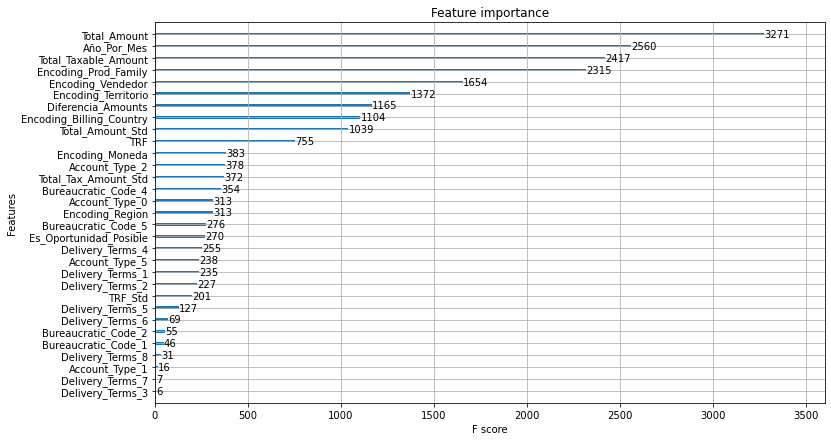

In [345]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)